Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

Get Data

ADRO (PT. Adaro Energy Tbk)

INCO (PT. Vale Indonesia Tbk)

ASII (PT. Astra International Tbk)

IMAS (PT. Indomobil Sukses Internasional Tbk)

TLKM (PT.Telekomunikasi Indonesia (Persero) Tbk)

GIAA (PT. Garuda Indonesia (Persero) Tbk)

In [ ]:
Perusahaan = 'GIAA' #masukkan kode saham
#-------------------------------------------------
locate = '/content/drive/My Drive/DataIDX per Perusahaan/'+ Perusahaan +'.csv'
df = pd.read_csv( locate,infer_datetime_format=True)
df.head(3)

,Unnamed: 0,Kode Saham,Nama Perusahaan,Sebelumnya,Open Price,First Trade,Tertinggi,Terendah,Penutupan,Selisih,Volume,Nilai,Frekuensi,Index Individual,Listed Shares,Offer,Offer Volume,Bid,Bid Volume,Last Trading Date,Tradeble Shares,Weight for Index,Foreign Sell,Foreign Buy,Non Regular Volume,Non Regular Value,Non Regular Frequency,Tanggal
0,240.0,GIAA,Garuda Indonesia (Persero) Tbk.,498.0,0.0,0.0,505.0,496.0,498.0,0.0,6170900.0,3.080066e+09,978.0,66.9,2.588658e+10,0.0,0.0,0.0,0.0,30 Des 2019,2.588658e+10,2.588658e+10,248500.0,204000.0,330062.0,164370876.0,2.0,2019/12/30
1,240.0,GIAA,Garuda Indonesia (Persero) Tbk.,500.0,0.0,0.0,505.0,498.0,498.0,-2.0,7075500.0,3.538462e+09,958.0,66.9,2.588658e+10,500.0,72400.0,498.0,1234400.0,27 Des 2019,2.588658e+10,2.588658e+10,478400.0,158400.0,36.0,17928.0,1.0,2019/12/27
2,240.0,GIAA,Garuda Indonesia (Persero) Tbk.,500.0,0.0,0.0,510.0,500.0,500.0,0.0,6204600.0,3.121016e+09,1035.0,67.2,2.588658e+10,505.0,650600.0,500.0,1922400.0,26 Des 2019,2.588658e+10,2.588658e+10,383100.0,158600.0,36.0,18000.0,1.0,2019/12/26


Data Cleaning
-Fitur Selection

In [ ]:
# Menghapus fitur atau kolom yang tidak dibutuhkan
df.drop(['Unnamed: 0',
         'Kode Saham',
         'Nama Perusahaan',
         'Last Trading Date',
         'Selisih',
         'Nilai',
         'Frekuensi',
         'Index Individual',
         'Listed Shares',
         'Offer',
         'Offer Volume',
         'Bid',
         'Bid Volume',
         'Last Trading Date',
         'Tradeble Shares',
         'Weight for Index',
         'Foreign Sell',
         'Foreign Buy',
         'Non Regular Volume',
         'Non Regular Value',
         'Non Regular Frequency',
         'Open Price',
         #'Sebelumnya',
         'First Trade',
         'Volume'],
         axis=1, inplace=True)

In [ ]:
# Proses ini berfungsi untuk mengurutkan data menurut waktu atau time series
# ubah tanggal jadi index
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%Y/%m/%d')
df = df.sort_values(by='Tanggal')
df = df.set_index('Tanggal')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1211 entries, 2015-01-05 to 2019-12-30
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sebelumnya  1211 non-null   float64
 1   Tertinggi   1211 non-null   float64
 2   Terendah    1211 non-null   float64
 3   Penutupan   1211 non-null   float64
dtypes: float64(4)
memory usage: 47.3 KB


In [ ]:
# BENTUK DATASET
df.head()

,Sebelumnya,Tertinggi,Terendah,Penutupan
Tanggal,,,,
2015-01-05,565.0,620.0,550.0,610.0
2015-01-06,610.0,635.0,600.0,635.0
2015-01-07,635.0,650.0,620.0,620.0
2015-01-08,620.0,630.0,610.0,620.0
2015-01-09,620.0,625.0,600.0,600.0


In [ ]:
# CEK NULL
df.isna().sum()

Sebelumnya    0
Tertinggi     0
Terendah      0
Penutupan     0
dtype: int64

*Fungsi Sliding Window*

In [ ]:
#fungsi membuat fitur jadi mempunyai time step atau 
#                 SLIDING WINDOWS

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Sliding Window + Labeling

In [ ]:
# inputkan panjang label pada variabel Label
# 1  = 1 hari
# 3  = 3 hari
# 7  = 1 minggu
# 14 = 2 minggu
# 30 = 1 bulan
Label = 30   

df_reframed = series_to_supervised(df,26,Label) 
df_reframed.head()
#var1 = open
#var2 = tertinggi
#var3 = terendah
#var4 = penutupan

,var1(t-26),var2(t-26),var3(t-26),var4(t-26),var1(t-25),var2(t-25),var3(t-25),var4(t-25),var1(t-24),var2(t-24),var3(t-24),var4(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var1(t-22),var2(t-22),var3(t-22),var4(t-22),var1(t-21),var2(t-21),var3(t-21),var4(t-21),var1(t-20),var2(t-20),var3(t-20),var4(t-20),var1(t-19),var2(t-19),var3(t-19),var4(t-19),var1(t-18),var2(t-18),var3(t-18),var4(t-18),var1(t-17),var2(t-17),var3(t-17),var4(t-17),...,var1(t+20),var2(t+20),var3(t+20),var4(t+20),var1(t+21),var2(t+21),var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var1(t+24),var2(t+24),var3(t+24),var4(t+24),var1(t+25),var2(t+25),var3(t+25),var4(t+25),var1(t+26),var2(t+26),var3(t+26),var4(t+26),var1(t+27),var2(t+27),var3(t+27),var4(t+27),var1(t+28),var2(t+28),var3(t+28),var4(t+28),var1(t+29),var2(t+29),var3(t+29),var4(t+29)
Tanggal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-11,565.0,620.0,550.0,610.0,610.0,635.0,600.0,635.0,635.0,650.0,620.0,620.0,620.0,630.0,610.0,620.0,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,...,500.0,515.0,500.0,505.0,505.0,510.0,495.0,499.0,499.0,505.0,497.0,500.0,500.0,510.0,498.0,500.0,500.0,520.0,500.0,515.0,515.0,525.0,515.0,520.0,520.0,520.0,496.0,500.0,500.0,505.0,497.0,498.0,498.0,505.0,492.0,492.0,492.0,497.0,476.0,486.0
2015-02-12,610.0,635.0,600.0,635.0,635.0,650.0,620.0,620.0,620.0,630.0,610.0,620.0,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,590.0,590.0,565.0,580.0,...,505.0,510.0,495.0,499.0,499.0,505.0,497.0,500.0,500.0,510.0,498.0,500.0,500.0,520.0,500.0,515.0,515.0,525.0,515.0,520.0,520.0,520.0,496.0,500.0,500.0,505.0,497.0,498.0,498.0,505.0,492.0,492.0,492.0,497.0,476.0,486.0,486.0,489.0,479.0,483.0
2015-02-13,635.0,650.0,620.0,620.0,620.0,630.0,610.0,620.0,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,590.0,590.0,565.0,580.0,580.0,600.0,580.0,585.0,...,499.0,505.0,497.0,500.0,500.0,510.0,498.0,500.0,500.0,520.0,500.0,515.0,515.0,525.0,515.0,520.0,520.0,520.0,496.0,500.0,500.0,505.0,497.0,498.0,498.0,505.0,492.0,492.0,492.0,497.0,476.0,486.0,486.0,489.0,479.0,483.0,483.0,489.0,480.0,485.0
2015-02-16,620.0,630.0,610.0,620.0,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,590.0,590.0,565.0,580.0,580.0,600.0,580.0,585.0,585.0,590.0,570.0,580.0,...,500.0,510.0,498.0,500.0,500.0,520.0,500.0,515.0,515.0,525.0,515.0,520.0,520.0,520.0,496.0,500.0,500.0,505.0,497.0,498.0,498.0,505.0,492.0,492.0,492.0,497.0,476.0,486.0,486.0,489.0,479.0,483.0,483.0,489.0,480.0,485.0,485.0,499.0,485.0,496.0
2015-02-17,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,590.0,590.0,565.0,580.0,580.0,600.0,580.0,585.0,585.0,590.0,570.0,580.0,580.0,605.0,585.0,600.0,...,500.0,520.0,500.0,515.0,515.0,525.0,515.0,520.0,520.0,520.0,496.0,500.0,500.0,505.0,497.0,498.0,498.0,505.0,492.0,492.0,492.0,497.0,476.0,486.0,486.0,489.0,479.0,483.0,483.0,489.0,480.0,485.0,485.0,499.0,485.0,496.0,496.0,505.0,488.0,492.0


**Labeling**

In [ ]:
Non_Label = 1
if Label == 1: Non_Label = -4
if Label == 3: Non_Label = -12
if Label == 7: Non_Label = -28
if Label == 14: Non_Label = -56
if Label == 30: Non_Label = -120 
df_reframed.drop(df_reframed.iloc[ : , Non_Label:-1 ], axis=1, inplace=True) #kolom selain label di time step t remove
df_reframed.head()

,var1(t-26),var2(t-26),var3(t-26),var4(t-26),var1(t-25),var2(t-25),var3(t-25),var4(t-25),var1(t-24),var2(t-24),var3(t-24),var4(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var1(t-22),var2(t-22),var3(t-22),var4(t-22),var1(t-21),var2(t-21),var3(t-21),var4(t-21),var1(t-20),var2(t-20),var3(t-20),var4(t-20),var1(t-19),var2(t-19),var3(t-19),var4(t-19),var1(t-18),var2(t-18),var3(t-18),var4(t-18),var1(t-17),var2(t-17),var3(t-17),var4(t-17),...,var2(t-10),var3(t-10),var4(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var1(t-8),var2(t-8),var3(t-8),var4(t-8),var1(t-7),var2(t-7),var3(t-7),var4(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t+29)
Tanggal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-11,565.0,620.0,550.0,610.0,610.0,635.0,600.0,635.0,635.0,650.0,620.0,620.0,620.0,630.0,610.0,620.0,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,...,600.0,590.0,590.0,590.0,600.0,585.0,595.0,595.0,605.0,590.0,595.0,595.0,595.0,585.0,585.0,585.0,595.0,560.0,565.0,565.0,570.0,555.0,560.0,560.0,575.0,560.0,570.0,570.0,575.0,560.0,560.0,560.0,560.0,535.0,540.0,540.0,545.0,510.0,535.0,486.0
2015-02-12,610.0,635.0,600.0,635.0,635.0,650.0,620.0,620.0,620.0,630.0,610.0,620.0,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,590.0,590.0,565.0,580.0,...,600.0,585.0,595.0,595.0,605.0,590.0,595.0,595.0,595.0,585.0,585.0,585.0,595.0,560.0,565.0,565.0,570.0,555.0,560.0,560.0,575.0,560.0,570.0,570.0,575.0,560.0,560.0,560.0,560.0,535.0,540.0,540.0,545.0,510.0,535.0,535.0,565.0,535.0,560.0,483.0
2015-02-13,635.0,650.0,620.0,620.0,620.0,630.0,610.0,620.0,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,590.0,590.0,565.0,580.0,580.0,600.0,580.0,585.0,...,605.0,590.0,595.0,595.0,595.0,585.0,585.0,585.0,595.0,560.0,565.0,565.0,570.0,555.0,560.0,560.0,575.0,560.0,570.0,570.0,575.0,560.0,560.0,560.0,560.0,535.0,540.0,540.0,545.0,510.0,535.0,535.0,565.0,535.0,560.0,560.0,570.0,545.0,545.0,485.0
2015-02-16,620.0,630.0,610.0,620.0,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,590.0,590.0,565.0,580.0,580.0,600.0,580.0,585.0,585.0,590.0,570.0,580.0,...,595.0,585.0,585.0,585.0,595.0,560.0,565.0,565.0,570.0,555.0,560.0,560.0,575.0,560.0,570.0,570.0,575.0,560.0,560.0,560.0,560.0,535.0,540.0,540.0,545.0,510.0,535.0,535.0,565.0,535.0,560.0,560.0,570.0,545.0,545.0,545.0,555.0,525.0,530.0,496.0
2015-02-17,620.0,625.0,600.0,600.0,600.0,630.0,600.0,620.0,620.0,625.0,610.0,615.0,615.0,620.0,605.0,610.0,610.0,615.0,595.0,605.0,600.0,605.0,580.0,590.0,590.0,590.0,565.0,580.0,580.0,600.0,580.0,585.0,585.0,590.0,570.0,580.0,580.0,605.0,585.0,600.0,...,595.0,560.0,565.0,565.0,570.0,555.0,560.0,560.0,575.0,560.0,570.0,570.0,575.0,560.0,560.0,560.0,560.0,535.0,540.0,540.0,545.0,510.0,535.0,535.0,565.0,535.0,560.0,560.0,570.0,545.0,545.0,545.0,555.0,525.0,530.0,530.0,530.0,510.0,520.0,492.0


Min Max Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
v = df_reframed.values
df_normalized = scaler.fit_transform(v)
df_normalized

array([[0.83908046, 0.93273543, 0.83372922, ..., 0.78535354, 0.77906977,
        0.66511628],
       [0.94252874, 0.96636771, 0.95249406, ..., 0.84848485, 0.8372093 ,
        0.65813953],
       [1.        , 1.        , 1.        , ..., 0.87373737, 0.80232558,
        0.6627907 ],
       ...,
       [0.70114943, 0.68609865, 0.71021378, ..., 0.87373737, 0.8372093 ,
        0.69767442],
       [0.68965517, 0.70852018, 0.71021378, ..., 0.8989899 , 0.87209302,
        0.69302326],
       [0.73563218, 0.7309417 , 0.73871734, ..., 0.8989899 , 0.8255814 ,
        0.69302326]])

Split Training , Validation, Testing Data

In [ ]:
from sklearn.model_selection import train_test_split
dataset = df_normalized
X = dataset[: , :-1]  # Dataset
Y = dataset[: , -1]   # Label
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
X_validation, X_Test, Y_validation, Y_Test = train_test_split(X_test, Y_test, test_size=0.66, shuffle=False)

In [ ]:
#reshape jadi 3D
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))
X_validation = X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))
print(X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape, X_Test.shape, Y_Test.shape) 

(809, 1, 104) (809,) (117, 1, 104) (117,) (230, 1, 104) (230,)


Pembentukan Arsitektur RNN-GRU

In [ ]:
unit1 = 200 #inisiasi banyak unit
unit2 = 100
DO1 = 0.5 #inisiasi Dropout 
DO2 = 0.2

model = tf.keras.models.Sequential([                                  
  tf.keras.layers.GRU(unit1, return_sequences=True),  
  #tf.keras.layers.Dropout(DO1),
  tf.keras.layers.GRU(unit2, return_sequences=True),
  #tf.keras.layers.Dropout(DO2),
  tf.keras.layers.Dense(1, activation="sigmoid") #inisialisasi output layer
])

In [ ]:
# Disini Penyimpan Model Terbaik diinisialisasi

#callback
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True) #H5

Inisialisasi parameter GRU

In [ ]:
#inisialisasi parameter RNN-GRU
model.compile(
              loss=tf.keras.losses.MAE,              # inisialisasi loss function
              optimizer=tf.keras.optimizers.Adam(),  # inisialisasi optimizer gradient descent
              metrics=["mae"])                       # inisialisasi  metrict metode pengujian (MAE dan RMSE)

Training

In [ ]:
Epoch = 300 # inisialisasi epoch

history = model.fit(X_train, 
                    Y_train, 
                    epochs=Epoch, 
                    validation_data=(X_validation, Y_validation), 
                    verbose=2,
                    batch_size = 252, # inisiasi batch
                    callbacks=[mc])

Epoch 1/300
4/4 - 5s - loss: 0.1771 - mae: 0.1771 - val_loss: 0.3939 - val_mae: 0.3939

Epoch 00001: val_mae improved from inf to 0.39394, saving model to best_model.h5
Epoch 2/300
4/4 - 0s - loss: 0.1668 - mae: 0.1668 - val_loss: 0.3866 - val_mae: 0.3866

Epoch 00002: val_mae improved from 0.39394 to 0.38664, saving model to best_model.h5
Epoch 3/300
4/4 - 0s - loss: 0.1502 - mae: 0.1502 - val_loss: 0.3820 - val_mae: 0.3820

Epoch 00003: val_mae improved from 0.38664 to 0.38204, saving model to best_model.h5
Epoch 4/300
4/4 - 0s - loss: 0.1392 - mae: 0.1392 - val_loss: 0.3645 - val_mae: 0.3645

Epoch 00004: val_mae improved from 0.38204 to 0.36451, saving model to best_model.h5
Epoch 5/300
4/4 - 0s - loss: 0.1218 - mae: 0.1218 - val_loss: 0.3266 - val_mae: 0.3266

Epoch 00005: val_mae improved from 0.36451 to 0.32660, saving model to best_model.h5
Epoch 6/300
4/4 - 0s - loss: 0.0974 - mae: 0.0974 - val_loss: 0.2970 - val_mae: 0.2970

Epoch 00006: val_mae improved from 0.32660 to 0.297

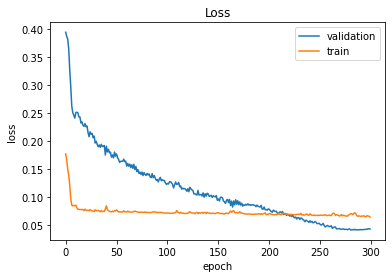

In [ ]:
import matplotlib.pyplot as plt

#tampilkan performa pada saat pelatihan
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation','train'], loc='upper right')
plt.show()

Uji dengan Model terbaik

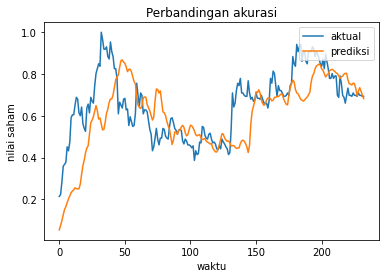

In [ ]:
from keras.models import load_model

#Load Best MODEL
model.save('best_model.h5')
Best_Model = load_model('best_model.h5')

#lakukan prediksi
prediksi = Best_Model.predict(X_Test)
Prediksi = prediksi.reshape((prediksi.shape[0]))

# Tampilkan perbandingan akurasi
plt.plot(Y_Test)
plt.plot(Prediksi)
plt.title('Perbandingan akurasi')
plt.ylabel('nilai saham')
plt.xlabel('waktu')
plt.legend(['aktual', 'prediksi'], loc='upper right')
plt.show()

Denormalisasi

In [ ]:
# Get data label Testing dengan urut waktu
rentang_label = 0
if Label == 1: rentang_label = 950
if Label == 3: rentang_label = 948
if Label == 7: rentang_label = 945
if Label == 14: rentang_label = 939
if Label == 30: rentang_label = 926

int_aktual = []
for x in df_reframed.iloc[ rentang_label: , -1]:
  int_aktual.append(round(x))
  
kolom_label = "kosong"
if Label == 1: kolom_label = "var4(t)"
if Label == 3: kolom_label = "var4(t+2)"
if Label == 7: kolom_label = "var4(t+6)"
if Label == 14: kolom_label = "var4(t+13)"
if Label == 30: kolom_label = "var4(t+29)"

DF_aktual = pd.DataFrame(df_reframed.iloc[ rentang_label: , -1]) 
DF_aktual = DF_aktual.rename({kolom_label:"Aktual"}, axis=1)
DF_aktual['Aktual'] = int_aktual
#DF_aktual.head()

Fungsi Denormalisasi

In [ ]:
# Fungsi mencari nilai Max()
def myMax(x):
  panjang = len(x)
  Vmax = 0 
  for i in x:
    if i > Vmax:
      Vmax = i
  
  return Vmax

# Fungsi mencari nilai Min()
def myMin(x):
  panjang = len(x)
  Vmin = x[0] 
  for i in x:
    if i < Vmin:
      Vmin = i
  
  return Vmin

# Fungsi Denormalisasi
def denormalize(x, min, max):
    final_value = x*(max - min) + min
    return round(final_value)

In [ ]:
# Cari Nilai Max() & Min()
min = myMin(df_reframed.iloc[:,-1])
max = myMax(df_reframed.iloc[:,-1])

# DENORMALISASI
denormalize_Prediksi = []
for y in Prediksi:
   denormalize_Prediksi.append(denormalize(y,min,max))

denormalize_aktual = []
for y in Y_Test:
  denormalize_aktual.append(denormalize(y,min,max))


# buat data Pengujian
DF_aktual['Prediksi'] = denormalize_Prediksi
DF_aktual['Aktual'] = denormalize_aktual
DF_Testing = DF_aktual
DF_Testing.head() 

,Aktual,Prediksi
Tanggal,,
2019-01-16,1460,1403
2019-01-17,1460,1426
2019-01-18,1485,1447
2019-01-21,1470,1442
2019-01-22,1410,1441


PENGUJIAN

Inisiasi Fungsi Pengujian

In [ ]:
from math import sqrt

# MAE
def MAE(y_prediksi, y_aktual):
  sum = 0
  for i in range(len(y_prediksi)):
    sum = sum + abs(y_aktual[i]-y_prediksi[i])
  return (sum/len(y_prediksi))

# RMSE  
def RMSE(y_prediksi, y_aktual):
  sum = 0
  for i in range(len(y_prediksi)):
    sum = sum + (y_aktual[i]-y_prediksi[i])**2
  return sqrt(sum/len(y_prediksi))

# DA
def DA(y_prediksi, y_aktual):
  sum = 0
  for i in range(len(y_prediksi)-1):
    value = (y_aktual[i+1]-y_aktual[i])*(y_prediksi[i+1]-y_prediksi[i])
    if value >= 0 :
      sum = sum + 1
  hasil = (sum/(len(y_prediksi)-1))*100
  return hasil

# MAPE
def MAPE(y_prediksi, y_aktual):
  sum = 0
  for i in range(len(y_prediksi)):
    sum = sum + (abs(y_aktual[i] - y_prediksi[i])/y_aktual[i])
  hasil = (sum/len(y_prediksi))*100
  return hasil

In [ ]:
mae = MAE(DF_aktual['Prediksi'],DF_aktual['Aktual'])
rmse = RMSE(DF_aktual['Prediksi'],DF_aktual['Aktual'])
da = DA(DF_aktual['Prediksi'],DF_aktual['Aktual'])
mape = MAPE(DF_aktual['Prediksi'],DF_aktual['Aktual'])
print("MAE  = "+ str(mae))
print("RMSE = "+ str(rmse))
print("DA   = "+ str(da) + " %")
print("MAPE = "+ str(mape) + " %")

MAE  = 41.57021276595745
RMSE = 52.62145020119263
DA   = 51.28205128205128 %
MAPE = 3.119959554184693 %


Presentasi Grafik Detail

In [ ]:
DF_aktual.to_csv("prediksiXaktual.csv")